Before running the analyses, mutational signatures have to be extracted (in our case, using SigProfilerJulia) and mSigAct has to be also run in HMF Colon-Rectum, Breast, Urinary-Tract and Ovary cohorts. 

Moreover, the treatment history of HMF patients is needed. We provide a set of scripts that parse the data, but we are not allowed to share HMF data.

In [1]:
import sys
import pandas as pd
from scipy.stats import iqr
import numpy as np

sys.path.append("../config")
from config import SIG_PROFILER_SBS, COLON_MUTS, COLON, M_SIG_ACT

## How run mSigAct

In [2]:
def read_PCAWG_sigs_file(pcawg_file):
    df_pcawg = pd.read_csv(pcawg_file)
    df_pcawg['mut'] = df_pcawg.apply(lambda x : '{}[{}>{}]{}'.format(x['SubType'][0], 
                                                                    x['SubType'][1],
                                                                     x['Type'][-1],
                                                                     x['SubType'][-1], 
                                                                    ), axis = 1)
    df_pcawg.set_index('mut', inplace = True)
    
    return df_pcawg

def remove_hypermutants(file):
    # Remove hypermutants
    df_col_muts = pd.read_csv(file, sep ='\t')

    dic_muts = df_col_muts.sum().to_dict()
    IQR = iqr(list(dic_muts.values()))
    median = np.median(list(dic_muts.values()))

    cutoff = median + 2.5 * IQR

    hypersamples = [s for s, v in dic_muts.items() if v > cutoff]
    nothypersamples = [s for s, v in dic_muts.items() if v <= cutoff]
    
    return nothypersamples, df_col_muts

def process_msigact(df_pcawg, df_col, selected_extracted_signatures, previous_pcawg, target, label, muts_file, hypermutants = False): 

    pcawg_subset = df_pcawg[previous_pcawg]
    observed_subset = df_col[selected_extracted_signatures]

    merged_sigs = pd.concat([pcawg_subset, observed_subset], axis = 1,)
    merged_sigs = merged_sigs/merged_sigs.sum()
    merged_sigs['index'] = [f'{ix[0]}{ix[2]}{ix[-1]}{ix[4]}' for ix in merged_sigs.index.tolist()]

    for name, signature_interest in target.items():
        cols_no_treatment = [col for col in merged_sigs.columns.tolist() if (col != signature_interest) & (col !='index')]
        mSigAct = merged_sigs[['index'] + cols_no_treatment + [signature_interest]]
        mSigAct.to_csv(f'{M_SIG_ACT}/{label}_SIGS_{name}.tsv', sep ='\t', index = False, header = True)
    
    if hypermutants is True:
        nothypersamples, df_col_muts = remove_hypermutants(muts_file)
        df_col_muts = df_col_muts[nothypersamples]
        
    cols_muts = df_col_muts.columns.tolist()
    df_col_muts['order'] = merged_sigs['index'].tolist()
    df_col_muts[['order'] + cols_muts].to_csv(f'{M_SIG_ACT}/{label}_muts.tsv', sep ='\t', index = False, header = True)



In [3]:
# Read PCAWG file
df_pcawg = read_PCAWG_sigs_file(SIG_PROFILER_SBS)

### Colon Example

In [4]:
# Different cohorts, with their atributes to run

# Breast
# signatures  17b and 5FU sig from colon-rectum extraction when targeting 5FU. Wanted sigs: SBS31 ,5FU
previous_pcawg = ['SBS1',  'SBS2', 'SBS3', 'SBS5', 'SBS8', 'SBS13', 
                  'SBS18', 'SBS36',  'SBS40', 'SBS31' ]  # + Capecitabine, 17 when targeting 5FU
label = "Breast"

# Lung
#  17b and 5FU sig from colon-rectum extraction when targeting 5FU. Wanted sigs: 2_1.0_SBS31-0.95 ,5FU
selected_extracted_signatures = ['2_1.0_SBS31-0.95']
previous_pcawg = ['SBS1', 'SBS2', 'SBS3', 'SBS4', 'SBS5', 'SBS13',
                  'SBS18',  'SBS40'] # + Capecitabine, 17 when when targeting 5FU
label = "Lung"

# Ovary. No hypermutants filter. Wanted sigs :  6_1.0_SBS31-0.92
selected_extracted_signatures = ['6_1.0_SBS31-0.92']
previous_pcawg = ['SBS1', 'SBS2', 'SBS3', 'SBS8', 'SBS5', 'SBS13', 'SBS18', 'SBS40']
label = "Ovary"

# Urinary-tract
# 17b and 5FU sig from colon-rectum extraction. Wanted sigs:7_1.0_SBS31-0.97 ,5FU
selected_columns = ['7_1.0_SBS31-0.97']       
previous_pcawg = ['SBS1',  'SBS2', 'SBS5', 'SBS6','SBS8', 'SBS13', 
                  'SBS18', 'SBS40']
label = "Urinary-tract"

In [5]:
# Input matrix (from SigProfilerJulia)
df_processes = pd.read_csv(COLON, sep ='\t', index_col=0)

# Not artefactual signatures. Assessed manually after signature extraction and postprocessing
selected_extracted_signatures = ['1_1.0_NA', '2_1.0_SBS17b-0.96', '4_1.0_NA',
                  '5_0.99_SBS17b-0.91', '6_1.0_NA', '10_0.99_NA', '11_0.99_NA']

# Signatures active in the tissue according to PCAWG
previous_pcawg = ['SBS1',  'SBS15', 'SBS18', 
                  'SBS26', 'SBS28', 'SBS36', 'SBS5', 'SBS40' ] 

# Target signatures
target = {"Oxaliplatin":"10_0.99_NA", 
         "Capecitabine":"2_1.0_SBS17b-0.96"}

label = "Colon-Rectum"

process_msigact(df_pcawg, df_processes, selected_extracted_signatures, previous_pcawg, target, label, COLON_MUTS, hypermutants = True)

# keep these available for the next tumor types
df_pcawg["Capecitabine"] = df_processes["2_1.0_SBS17b-0.96"]
df_pcawg["17"] = df_processes["5_0.99_SBS17b-0.91"]

In [6]:
# Mutation file <- '../../data/mutfootprints_2020/hartwig/signatures/mSigAct/Colon-Rectum_muts.tsv'
# Signature file <- '../../data/mutfootprints_2020/hartwig/signatures/mSigAct/Colon-Rectum_SIGS_Capecitabine.tsv'
# Outpath <- '../../data/mutfootprints_2020/hartwig/signatures/mSigAct_results'

Now we can run mSigAct. This requires the mSigAct-1.2-alpha-branch. Please install this specific version as some of the scripts are not compatible with newer releases.

**You should adapt the mSigAct.R script so that it points to your install dir.**



```
Rscript ../signatures/mSigAct.R Colon-Rectum_muts.tsv Colon-Rectum_SIGS_Capecitabine.tsv out_msigact 
```

# Processing the data


In [7]:
import gzip
import pickle
from collections import defaultdict

sys.path.append("../signatures/")
from timing_functions import create_subtypes, get_timing_stats, plot_timing_distributions, distant_seeding

from config import SIG_TREATMENT_DRUG_LVL, SIG_TREATMENT_DRUG_LVL_DAYS, SIG_TREATMENT_DRUG_LVL_END, SIG_TREATMENT_DRUG_LVL_START
from config import SIG_EXTRACT_OVARY, SIG_EXTRACT_URINARY, SIG_EXTRACT_COLON, SIG_EXTRACT_BREAST
from config import SIG_RESULT_CR_CAPECITABINE, SIG_RESULT_CR_OXALIPLATIN, SIG_RESULT_O_CAPECITABINE, SIG_RESULT_UT_PLATINUM, SIG_RESULT_BR_PLATINUM, SIG_RESULT_BR_CAPECITABINE

In [8]:
# load treatment info

treatment_sample_level = pickle.load(gzip.open(SIG_TREATMENT_DRUG_LVL))
treatment_sample_days_treatment = pickle.load(gzip.open(SIG_TREATMENT_DRUG_LVL_DAYS))
treatment_sample_days_biopsy_since_end_treatment = pickle.load(gzip.open(SIG_TREATMENT_DRUG_LVL_END))
treatment_sample_days_biopsy_since_start_treatment = pickle.load(gzip.open(SIG_TREATMENT_DRUG_LVL_START))

In [9]:
dic_prop_ttypes = defaultdict(dict)
toregs = []

### Capecitabine Colon-Rectum

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


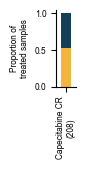

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


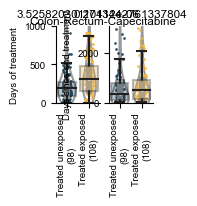

3.331168831168831 0.001969262225685107


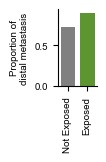

In [10]:
df_msig = pd.read_csv(SIG_RESULT_CR_CAPECITABINE, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_COLON, sep ='\t', index_col = 0).T

drug = 'Capecitabine'
ttype = 'Colon-Rectum'

# Finding agreement between exposures. This will partially create Figure 2B
agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = True)

# Get timing stats
t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

# exposed_days_since_start, notexposed_days_since_start NOT USED !! 
exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t


# Plot differences between times of treatment 
plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end, 
                      drug, ttype, 900, 3000)


# Get proximal/distal differences
distant = ['Liver', 'Lung', 'Breast', 'Neck', 'Bone', 'Vagina', 'Skin']
close = ['Colon', 'Lymph', 'Peritoneum', 'SI', 'Primary']
dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)



### Oxaliplatin Colon-Rectum

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


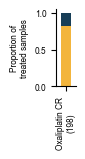

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


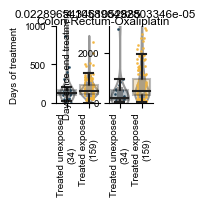

1.5480769230769231 0.4319505920469583


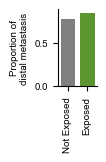

In [11]:
#file_msig = '/workspace/projects/reverse_calling/data/mSigAct_res_fin/Colon-Rectum/results.Colon-Rectum.mSigAct.X10_0.99_NA.10.tsv'
df_msig = pd.read_csv(SIG_RESULT_CR_OXALIPLATIN, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_COLON, sep ='\t', index_col = 0).T

drug = 'Oxaliplatin'
ttype = 'Colon-Rectum'

# Finding agreement between exposures. This will partially create Figure 2B
agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = True)

# Get timing stats
t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t


# plot differences between times of treatment 
plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end,
                      drug, ttype, 900, 3000)


# get proximal/distal differences
distant = ['Liver', 'Lung', 'Breast', 'Neck', 'Bone', 'Vagina', 'Adrenal', 'Skin']
close = ['Colon', 'Lymph', 'Peritoneum', 'Abdominal wall right', ]

dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)

### Carboplatin Ovary

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


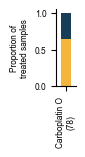

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


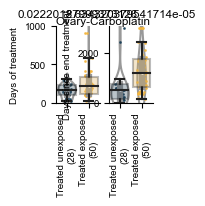

2.24 0.18850454247074921


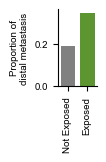

In [12]:
#file_msig = '/workspace/projects/reverse_calling/data/mSigAct_res_fin/Ovary/results.Ovary.mSigAct.X6_1.0_SBS31.0.92.10.tsv'
df_msig = pd.read_csv(SIG_RESULT_O_CAPECITABINE, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_OVARY, sep ='\t', index_col = 0).T

drug = 'Carboplatin'
ttype = 'Ovary'

# finding agreement between exposures. This will partially create Figure 2B
agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = True)

# get timing stats
t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t


# plot differences between times of treatment 
plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end,
                      drug, ttype, 900, 3000)


# get proximal/distal differences

distant = ['Liver', 'Lung', 'Breast', 'Neck', 'Bone', 'Vagina', 'Colon',  'Bladder', 'Skin']
close = ['Lymph', 'Primary', 'Omentum', 'Peritoneum','intraperitoneal deposition' ]


dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)

### Urinary-tract Cisplatin

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


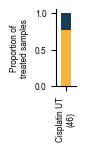

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


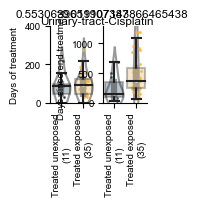

1.7333333333333334 0.7190171456874896


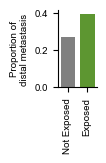

In [13]:
df_msig = pd.read_csv(SIG_RESULT_UT_PLATINUM, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_URINARY, sep ='\t', index_col = 0).T

drug = 'Cisplatin'
ttype = 'Urinary-tract'

agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = True)

t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t

plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end, 
                      drug, ttype, 300, 1200)



distant = ['Liver', 'Lung', 'Breast', 'Neck', 'Bone', 
           'Vagina', 'Colon', 'Brain', 'omental lesion' ]
close = ['Lymph', 'Primary', 'Bladder', 
         'Peritoneum', 'intraperitoneal deposition', 'Adrenal', 'omental lesion']


dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)

### Breast Carboplatin

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


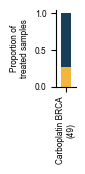

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


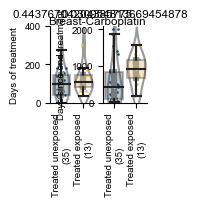

1.4583333333333333 0.731486798985383


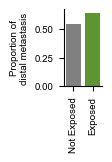

In [14]:
#file_msig = '/workspace/projects/reverse_calling/data/mSigAct_res_fin/Breast/results.Breast.mSigAct.SBS31.10.tsv'
df_msig = pd.read_csv(SIG_RESULT_BR_PLATINUM, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_BREAST, sep ='\t', index_col = 0).T

drug = 'Carboplatin'
ttype = 'Breast'

agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = False)

t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t

plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end, drug, ttype, 300, 2000)

distant = ['Liver', 'Lung',  'Neck', 'Bone', 
           'Vagina', 'Colon', 'Brain', 'Adrenal', 'Peritoneum']
close = ['Lymph', 'Primary', 'Breast', 'Skin' ]

dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)

### Breast Capecitabine

../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "va" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')
../signatures/timing_functions.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ha" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/{}/{}_{}.agreement.svg'.format(FIG_2, ttype, drug), va='top', ha='right')


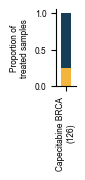

../signatures/timing_functions.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


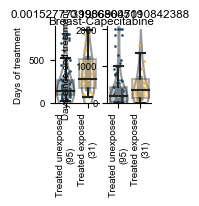

1.0714285714285714 1.0


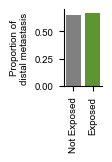

In [15]:
df_msig = pd.read_csv(SIG_RESULT_BR_CAPECITABINE, sep ='\t')
df_exp = pd.read_csv(SIG_EXTRACT_BREAST, sep ='\t', index_col = 0).T

drug = 'Capecitabine'
ttype = 'Breast'

agree_exposed, agree_not_exposed = create_subtypes(treatment_sample_level, ttype, drug, df_msig,
                df_exp, 0.05, sig_found = False)

t = get_timing_stats(agree_exposed, agree_not_exposed,drug, 
                    treatment_sample_days_treatment, treatment_sample_days_biopsy_since_start_treatment,
                    treatment_sample_days_biopsy_since_end_treatment)

exposed_days, notexposed_days, exposed_days_since_start, notexposed_days_since_start, exposed_days_since_end, notexposed_days_since_end  = t

plot_timing_distributions(exposed_days, notexposed_days, exposed_days_since_end, notexposed_days_since_end, 
                      drug, ttype, 800, 2000)


distant = ['Liver', 'Lung',  'Neck', 'Bone', 
           'Vagina', 'Colon', 'Brain', 'Adrenal', 'Peritoneum']
close = ['Lymph', 'Primary', 'Breast','Skin', 'Pleura' ]


dic_prop_ttypes, toregs = distant_seeding(agree_exposed, agree_not_exposed, drug, ttype, distant, close, dic_prop_ttypes, 
               treatment_sample_days_treatment, treatment_sample_days_biopsy_since_end_treatment, toregs)

# Merged

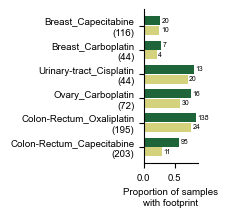

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from config_plot import config_plot_params 

fig, ax = plt.subplots(1, 1, figsize = (0.7, 2))
total = []
config_plot_params(5)
for ix, (t, k) in enumerate(dic_prop_ttypes.items()):
    close_exposed, close_notexposed, distant_exposed, distant_notexposed = k
    plt.barh(ix-0.2, close_exposed/(close_notexposed +close_exposed), height=0.375,
             color ='#D4D27C', edgecolor = '#5d9631ff', lw = 0)
    plt.barh(ix+0.2, distant_exposed/(distant_notexposed +distant_exposed),color =  '#1E653A',
            edgecolor = 'grey', lw = 0, height=0.375)
   
    plt.text((distant_exposed/(distant_notexposed +distant_exposed))+0.025,
            ix+0.145, distant_exposed )
    plt.text((close_exposed/(close_notexposed +close_exposed))+0.025,
            ix-0.245, close_exposed )   
    total.append(close_exposed + close_notexposed + distant_exposed + distant_notexposed)
    
plt.yticks(np.arange(len(dic_prop_ttypes))
           , ['{}\n({})'.format(k, t) for k, t in zip(dic_prop_ttypes.keys(), total)] 
           )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Proportion of samples\nwith footprint')

plt.show()

# Do regressions

In [17]:
from config import REGRESSION_INPUT
res = pd.concat(toregs).fillna(0)

In [18]:
res["Platin"] = res["Oxaliplatin"] + res["Carboplatin"] + res["Cisplatin"]

In [19]:
res.drop(["Cisplatin", "Oxaliplatin", "Carboplatin"], axis = 1, inplace = True)

In [20]:
res.columns = ["days_treat", "days_since_end", "prox_v", "exp", 
              "Colon-Rectum", "Capecitabine",
               "Ovary", "Urinary-Tract", "Breast" , "Platin",]

In [21]:
res.to_csv(REGRESSION_INPUT, sep ="\t", index = False, header = True)

In [31]:
# Scripts based on Ferran's Muinos LogReg

import sys
import pandas as pd
import patsy
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.eval_measures import bic, aic
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append("../config")
from config_plot import config_plot_params
from config import REGRESSION_INPUT, FIG_2
    
def dedummyfy_ttype(r):
    for ttype in ['Colon-Rectum', 'Ovary', 'Urinary-Tract', 'Breast']:
        if r[ttype] == 1:
            return ttype
    return 'Breast'

def dedummyfy_treatment(r):
    for ttype in ['Capecitabine', 'Platin']:
        if r[ttype] == 1:
            return ttype
    return 'Platin'

def logistic_regression(formula):
    
    y, X = patsy.dmatrices(formula, input_reg, return_type='matrix')
    logit = Logit(y, X)
    res = logit.fit(disp=0)
    return res, logit

def llf(res):
    return res._results._cache['llf']
    
def df_model(res):
    return res._results.df_model + 1
    
def df_residuals(res):
    return res._results.df_resid

def cv_score(model, data, formula, method='cross-entropy'):
    
    scores = []
    y, X = patsy.dmatrices(formula, input_reg, return_type='matrix')
    y = np.array(y)
    X = np.array(X)
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                           random_state = i)
        logit = Logit(y_train, X_train)
        res = logit.fit(disp=0)
        y_pred = res.predict(X_test)
        if method == 'cross-entropy':
            scores.append(log_loss(y_test, y_pred))
        else:
            scores.append(roc_auc_score(y_test, y_pred))
    return scores


# Capecitabine

In [23]:
input_reg = pd.read_csv(REGRESSION_INPUT, sep='\t')

In [24]:
config_plot_params(6)

input_reg['tumor_type'] = input_reg.apply(lambda x: dedummyfy_ttype(x), axis=1)
input_reg['treatment'] = input_reg.apply(lambda x: dedummyfy_treatment(x), axis=1)
input_reg = input_reg[input_reg['treatment']=='Capecitabine']
input_reg.drop(['treatment', 'Ovary', 'Capecitabine', 'Platin', 'Urinary-Tract'], axis =1, inplace = True)

In [25]:
aics = []
bics = []

formulas = [
    'exp ~ 1',
    'exp ~ 1 + days_treat',
    'exp ~ 1 + days_since_end',
    'exp ~ 1 + prox_v',
    'exp ~ 1 +  days_treat + days_since_end + prox_v',
    'exp ~ 1 +  days_treat + days_since_end + prox_v + tumor_type',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end + prox_v',
    'exp ~ 1 +  days_treat + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end*tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end*tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end*tumor_type + prox_v*tumor_type',
    'exp ~ 1 +  days_treat*days_since_end*tumor_type + prox_v',

]

for formula in formulas:

    res, logit = logistic_regression(formula)
    res.summary()

    a = aic(llf(res), df_residuals(res), df_model(res))
    b = bic(llf(res), df_residuals(res), df_model(res))

    aics.append(a)
    bics.append(b)

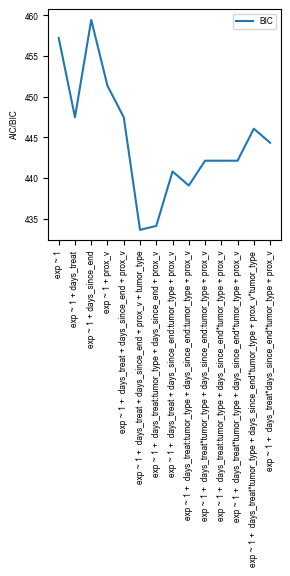

In [26]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
#plt.plot(aics, label='AIC')
plt.plot(bics, label='BIC')
plt.xticks(range(len(formulas)), formulas, rotation=90)
plt.ylabel('AIC/BIC')
plt.legend()
plt.show()

In [27]:
x = []
y = []
m_y = []
tobox = []
for i, formula in tqdm(enumerate(formulas)):
    scores = cv_score(Logit, input_reg, formula, method='roc')
    x += [i] * len(scores)
    y += scores
    tobox.append(scores)
    m_y += [np.median(scores)]

14it [00:04,  2.95it/s]


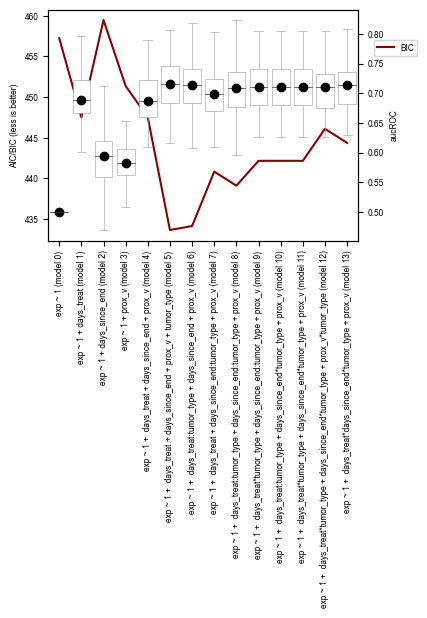

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4, 3))

ax2 = ax.twinx()
ax.set_xticks([])
ax.set_xticklabels([])


ax2.scatter(range(len(formulas)), m_y, color = 'black', label='median score')

sns.boxplot(data = tobox, showfliers = False, 
            color = 'white',
            medianprops={'color':'black'}, linewidth = 0.4, ax = ax2, zorder = 1)

ax.plot(bics, color = 'darkred', label='BIC', zorder=123)
ax.set_ylabel('AIC/BIC (less is better)')
ax.legend(loc=(1.05,0.8))

model_labels = [f'{f} (model {i})' for i, f in enumerate(formulas)]

ax2.set_xticks(range(len(formulas)))
ax2.set_xticklabels(model_labels,rotation = 90 )

ax.set_xticks(range(len(formulas)))
ax.set_xticklabels(model_labels,rotation = 90 )
ax2.set_ylabel('aucROC')

plt.show()

# select BIC

In [29]:
formula = formulas[5]
res, logit = logistic_regression(formula)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    exp   No. Observations:                  332
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            4
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                  0.1036
Time:                        10:58:22   Log-Likelihood:                -202.34
converged:                       True   LL-Null:                       -225.71
Covariance Type:            nonrobust   LLR p-value:                 1.721e-09
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.0306      0.324     -6.271      0.000      -2.665      -1.396
tumor_type[T.Colon-Rectum]     1.1443      0.266      4.294      0.000       0.622       1.667
days_treat                     0.3183      0.095      3.345      0.001       0.132       0.505
days_since_end                 0.0006      0.039      0.015      0.988      -0.076       0.077
prox_v                         0.6538      0.286      2.286      0.022       0.093       1.214
==============================================================================================
"""

0 0 Intercept
1 0 tumor_type[T.Colon-Rectum]
2 0 days_treat
3 1 days_since_end
4 2 prox_v


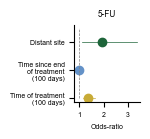

In [32]:
config_plot_params(5)

params = ['Intercept', 'tumor_type[T.Colon-Rectum]', 'days_treat', 'days_since_end', 'prox_v']


fig, ax = plt.subplots(1, 1, figsize = (0.85,1))
colors = ['#C8AB37' , '#6492C8', '#1E653A']
ix = 0
for v, i in enumerate(params):        
    print(v, ix, i)
    if i in ['days_treat', 'days_since_end', 'prox_v']:
        plt.scatter(np.exp(res.params[v]), ix, color = colors[ix])
        plt.plot([np.exp(res.conf_int()[v][0]),
                  np.exp(res.conf_int()[v][1])], [ix, ix], 
                color = colors[ix], lw = 0.5)
        ix+=1
        
#plt.xlim(0, 3.5)
plt.vlines(1, 0, 2.5, ls = '--', lw = 0.5, color = 'grey')
plt.yticks([2, 1, 0], ['Distant site',
                      'Time since end\nof treatment\n(100 days)',
                       'Time of treatment\n(100 days)'])
plt.title('5-FU')
plt.xlabel('Odds-ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{FIG_2}/cape_reg.svg')
plt.show()


# Platin

In [33]:
input_reg = pd.read_csv(REGRESSION_INPUT, sep='\t')

In [34]:
input_reg['tumor_type'] = input_reg.apply(lambda x: dedummyfy_ttype(x), axis=1)
input_reg['treatment'] = input_reg.apply(lambda x: dedummyfy_treatment(x), axis=1)
input_reg = input_reg[input_reg['treatment']=='Platin']
input_reg = input_reg[input_reg['tumor_type']!='Breast']
input_reg.drop(['treatment', 'Capecitabine'], axis =1, inplace = True)

In [35]:
aics = []
bics = []

formulas = [
    'exp ~ 1',
    'exp ~ 1 + days_treat',
    'exp ~ 1 + days_since_end',
    'exp ~ 1 + prox_v',
    'exp ~ 1 +  days_treat + days_since_end + prox_v',
    'exp ~ 1 +  days_treat + days_since_end + prox_v + tumor_type',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end + prox_v',
    'exp ~ 1 +  days_treat + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end:tumor_type + prox_v',
    'exp ~ 1 +  days_treat:tumor_type + days_since_end*tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end*tumor_type + prox_v',
    'exp ~ 1 +  days_treat*tumor_type + days_since_end*tumor_type + prox_v*tumor_type',
    'exp ~ 1 +  days_treat*days_since_end*tumor_type + prox_v',

]

for formula in formulas:

    res, logit = logistic_regression(formula)
    res.summary()

    a = aic(llf(res), df_residuals(res), df_model(res))
    b = bic(llf(res), df_residuals(res), df_model(res))

    aics.append(a)
    bics.append(b)

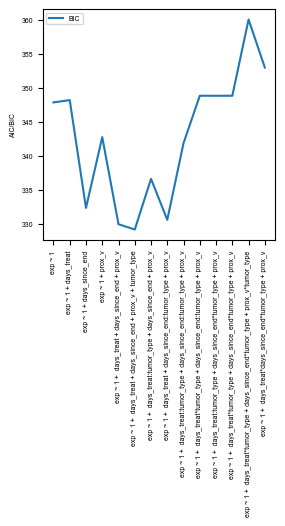

In [36]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
plt.plot(bics, label='BIC')
plt.xticks(range(len(formulas)), formulas, rotation=90)
plt.ylabel('AIC/BIC')
plt.legend()
plt.show()

In [37]:
x = []
y = []
m_y = []
tobox = []
for i, formula in tqdm(enumerate(formulas)):
    try :
        scores = cv_score(Logit, df, formula, method='roc')
    except:
        scores = [np.nan]
    x += [i] * len(scores)
    y += scores
    tobox.append(scores)
    m_y += [np.median(scores)]

14it [00:00, 4884.40it/s]


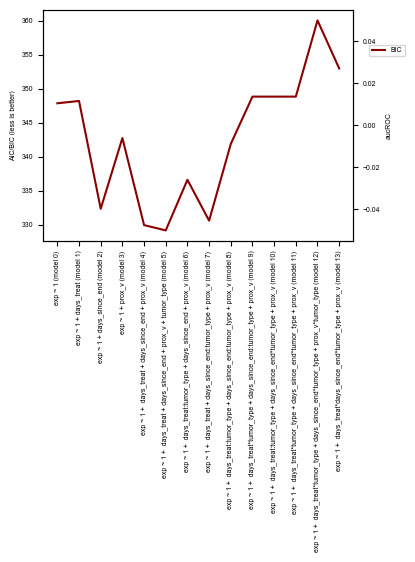

In [38]:
fig, ax = plt.subplots(1,1, figsize=(4, 3))
ax2 = ax.twinx()

ax.set_xticks([])
ax.set_xticklabels([])

ax2.scatter(range(len(formulas)), m_y, color = 'black', label='median score')
sns.boxplot(data = tobox, showfliers = False, 
            color = 'white',
            medianprops={'color':'black'}, linewidth = 0.4, ax = ax2, zorder = 1)

ax.plot(bics, color = 'darkred', label='BIC', zorder=123)
ax.set_ylabel('AIC/BIC (less is better)')
ax.legend(loc=(1.05,0.8))

model_labels = [f'{f} (model {i})' for i, f in enumerate(formulas)]

ax2.set_xticks(range(len(formulas)))
ax2.set_xticklabels(model_labels,rotation = 90 )

ax.set_xticks(range(len(formulas)))
ax.set_xticklabels(model_labels,rotation = 90 )
ax2.set_ylabel('aucROC')

plt.show()

# select BIC

In [39]:
formula = formulas[5]
res, logit = logistic_regression(formula)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    exp   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:                  0.1385
Time:                        10:59:33   Log-Likelihood:                -147.37
converged:                       True   LL-Null:                       -171.06
Covariance Type:            nonrobust   LLR p-value:                 4.761e-09
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0009      0.401      0.002      0.998      -0.785       0.787
tumor_type[T.Ovary]            -1.1696      0.390     -2.996      0.003      -1.935      -0.404
tumor_type[T.Urinary-Tract]     0.2414      0.450      0.536      0.592      -0.641       1.124
days_treat                      0.2760      0.261      1.058      0.290      -0.235       0.787
days_since_end                  0.3034      0.077      3.956      0.000       0.153       0.454
prox_v                          0.6970      0.342      2.036      0.042       0.026       1.368
===============================================================================================
"""

In [40]:
params = ['Intercept', 'tumor_type[T.Ovary]', 'tumor_type[T.Urinary-Tract]', 
          'days_treat', 'days_since_end', 'prox_v']


0 0 Intercept
1 0 tumor_type[T.Ovary]
2 0 tumor_type[T.Urinary-Tract]
3 0 days_treat
4 1 days_since_end
5 2 prox_v


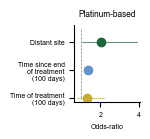

In [41]:
config_plot_params(5)

fig, ax = plt.subplots(1, 1, figsize = (0.85,1))
colors = ['#C8AB37' , '#6492C8', '#1E653A']
ix = 0
for v, i in enumerate(params):        
    print(v, ix, i)
    if i in ['days_treat', 'days_since_end', 'prox_v']:
        plt.scatter(np.exp(res.params[v]), ix, color = colors[ix])
        plt.plot([np.exp(res.conf_int()[v][0]),
                  np.exp(res.conf_int()[v][1])], [ix, ix], 
                color = colors[ix], lw = 0.5)
        ix+=1
        
#plt.xlim(0, 3.5)
plt.vlines(1, 0, 2.5, ls = '--', lw = 0.5, color = 'grey')
plt.yticks([2, 1, 0], ['Distant site',
                      'Time since end\nof treatment\n(100 days)',
                       'Time of treatment\n(100 days)'])
plt.title('Platinum-based')
plt.xlabel('Odds-ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('FIG_2/plati_reg.svg')
plt.show()


# Supplementary

## 3b

In [40]:
def get_percentage_clonal(exp, full):
    dic_sample_proportion = defaultdict(float)
    
    points = []
    
    for sample, data in tqdm(exp.groupby(by='SAMPLE')):
        all_clon_full = full[(full['SAMPLE']==sample)&(full['timing_class'].isin(['clonal [late]', 
                                               'clonal [NA]', 'clonal [early]']))]


        all_subclon_full = full[(full['SAMPLE']==sample) & (full['timing_class'].isin(['subclonal']))]

        all_clon = data[data['timing_class'].isin(['clonal [late]', 
                                                   'clonal [NA]', 'clonal [early]'])]
        all_subclon = data[data['timing_class'].isin(['subclonal'])]

        # if 100 subclonal mutations, get the proportion of clonal mutations of the signature
        if len(all_subclon_full)>50:
            dic_sample_proportion[sample] = len(all_clon)/len(data)
        
    return dic_sample_proportion

In [ ]:
from config import ML_OVARY, ML_UT

# Please look at the mutational footprints of cancer therapies to know how these files are generated

df_m_ovary = pd.read_csv(ML_OVARY, sep ='\t')
subs_exposed_ovary = df_m_ovary[(df_m_ovary['ML']=='6_1.0_SBS31-0.92')&(df_m_ovary['SAMPLE'].isin(agree_exposed_ovary))]

df_m_urinary = pd.read_csv(ML_UT, sep ='\t', usecols = ['SAMPLE', 'ML', 'timing_class'])
subs_exposed_urinary = df_m_urinary[(df_m_urinary['ML']=='7_1.0_SBS31-0.97')&(df_m_urinary['SAMPLE'].isin(agree_exposed_urinary))]

colon = '/workspace/users/opich/bg/mutfootprints_2020/data/hartwig/timing/merged/ML/Colon-Rectum.ML.SNV.gz'
df_m_colon = pd.read_csv(colon, sep ='\t', usecols = ['SAMPLE', 'ML', 'timing_class'])

subs_exposed_colon_capecitabine = df_m_colon[(df_m_colon['ML']=='2_1.0_SBS17b-0.96')&(df_m_colon['SAMPLE'].isin(agree_exposed_colon_capecitabine))]
subs_exposed_colon_oxaliplatin = df_m_colon[(df_m_colon['ML']=='10_0.99_NA')&(df_m_colon['SAMPLE'].isin(agree_exposed_colon_oxal))]

In [ ]:
import json

out_capecitabine_colon = get_percentage_clonal(subs_exposed_colon_capecitabine, df_m_colon)
out_oxaliplatin_colon = get_percentage_clonal(subs_exposed_colon_oxaliplatin, df_m_colon)
out_carboplatin_ovary = get_percentage_clonal(subs_exposed_ovary, df_m_ovary)
out_cisplatin_urinary = get_percentage_clonal(subs_exposed_urinary, df_m_urinary)


dic_treatment = json.load(open(TREATMENT_DIC))
platinum_based = []
for sample, l in dic_treatment.items():
    if 'Platinum-based Drug' in l:
        platinum_based.append(str(sample))

platinum_based.append(str(864484))

In [ ]:
df_ml = pd.read_csv(AML_ALL_HEMATO_ML, sep ='\t', low_memory=False)

subs = df_ml[(df_ml['PATIENT'].isin(platinum_based))&(df_ml['ML']=='1_0.97_SBS31-0.95')]
keep = []
d_aml = {}
for pat, data in subs.groupby('PATIENT'):
    d_aml[pat] = len(data[data['Clonal1']=='clonal'])/len(data)
    keep.append(len(data[data['Clonal1']=='clonal'])/len(data))
    
mean_uri = np.mean(list(out_cisplatin_urinary.values()))
mean_ovary = np.mean(list(out_carboplatin_ovary.values()))
mean_oxal = np.mean(list(out_oxaliplatin_colon.values()))
mean_fluor = np.mean(list(out_capecitabine_colon.values()))


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (1.2, 1.2))
dics = [out_capecitabine_colon, out_cisplatin_urinary, out_oxaliplatin_colon, out_carboplatin_ovary]
colors = ['Black', 'darkred', 'Orange' ,'#173E57', 'darkred']
labels = ['Colon 5-FU', 'Urinary-Tract Cisplatin', 'Colon Oxaliplatin', 'Ovary Carboplatin']
toplot = []
for ix, d in enumerate(dics):
    box = []
    for k, v in d.items():
        plt.scatter(ix+np.random.normal(0, 0.05), v, color = colors[ix], s = 2)
        box.append(v)
    toplot.append(box)
    
ax=sns.boxplot(data=toplot, showfliers=False, color = 'white',
            medianprops={'color':'black'}, linewidth = 0.4, ax = ax) 

plt.xticks(np.arange(len(labels)), labels, rotation = 90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Proportion of treatment\nclonal mutations')
plt.show()